In [413]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import googlemaps
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import itertools
from sklearn import svm
from statsmodels.tsa.seasonal import seasonal_decompose
from configparser import ConfigParser
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import RepeatedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [217]:
# get data
data_orig = pd.read_csv('./data/orders_autumn_2020.csv')
data_orig.set_index('TIMESTAMP', inplace=True)
print(data_orig.columns)
data = pd.read_csv('./data/orders_autumn_2020_aug.csv')
data.set_index('TIMESTAMP', inplace=True)
data.index = pd.to_datetime(data.index)
print(data.columns)

Index(['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES', 'ITEM_COUNT',
       'USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG',
       'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
       'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION'],
      dtype='object')
Index(['EST_ACT_Diff', 'ITEM_COUNT', 'USER_LAT', 'USER_LONG', 'VENUE_LAT',
       'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
       'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION',
       'USER_VENUE_DIST', 'DayOfWeek', 'user_coordinates', 'venue_coordinates',
       'venue_postal_code', 'user_postal_code', 'source_of_order_pcode'],
      dtype='object')


In [218]:
def calculate_distance(row):
    usercoord = (row['USER_LAT'], row['USER_LONG'])
    print(usercoord)
    venue_coord = (row['VENUE_LAT'], row['VENUE_LONG'])
    print(venue_coord)
    print(geodesic(user_coord, venue_coord).km)
    return geodesic(user_coord, venue_coord).km

# data[['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG']].apply(calculate_distance, axis=1)

In [8]:
# # Calculate delivery distance
# user_coord = data[['USER_LAT', 'USER_LONG']].values
# venue_coord = data[['VENUE_LAT', 'VENUE_LONG']].values
# user_venue_dist = [geodesic(user_coord[i], venue_coord[i]).km for i in range(data.shape[0])]

# #format the data
# data['USER_VENUE_DIST'] = user_venue_dist
# #data.drop(columns=['USER_LAT', 'USER_LONG', 'VENUE_LAT', 'VENUE_LONG'], inplace=True)
# data.rename(columns={'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES':'EST_ACT_Diff'}, inplace=True)
# data.index = pd.to_datetime(data.index)
# orig_data_desc = data.describe().T
# orig_data_desc
# # orig_data_desc.to_csv('docs/assets/tables/orig_data_stats.csv')

# Data Exploration

### Background:
In this section, the main goal is explore the data to obtain a better understanding before any modelling is undertaken

### Problem
Exploration of the data helps in identifying relationships between variables/features and provides some insights into how the data modelling stage could be carried out.

### Solution
This section will explore some basic statistical properties of the data mainly using tools such as correlation analysis and distributions of the data. This could also be considered as production of analytics from the dataset.

### 1) Distribution of key variables
The graphs below indicate the following:
- Distribution of the distance between users and venues: The average of the distance between users and venues is about 1.0Km. However, some deliveries tend to be further away almost 2.0-5.0Km as show by the positively skewed graph.
- Distribution of item count, these are understood to be the number of items in an order: This graph shows that a significant bulk of the orders are made up of one item and the graph is equally skewed to the right, which indicates some orders that tend to contain a high number of items in the order. The maximum observed was 11 items while the 75 percentile is 4 items.
- Distribution of the accuracies between estimated minutes and actual minutes: This graph was rather  statistically interesting, it shows are a very "normal" looking distribution indicating there are almost as many over estimates of the time it takes to deliver as they are under estimates. Either the estimating process makes very consistent errors although the average error is -1.2 Minutes

<AxesSubplot:xlabel='EST_ACT_Diff', ylabel='Count'>

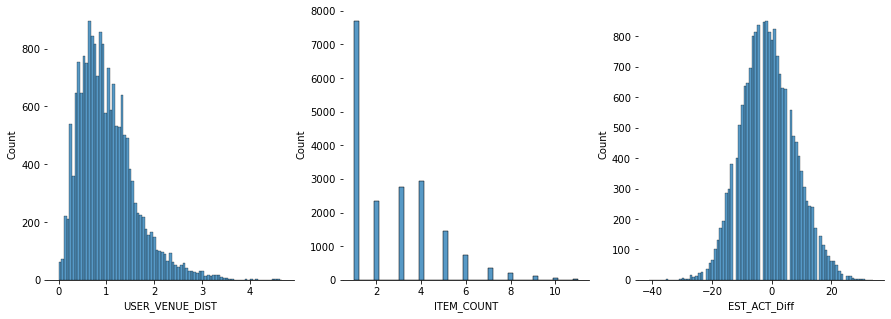

In [432]:
# Distribution of key features
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
sns.histplot(data=data['USER_VENUE_DIST'], ax=ax[0])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
sns.histplot(data=data['ITEM_COUNT'], ax=ax[1])

ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
sns.histplot(data=data['EST_ACT_Diff'], ax=ax[2])

In [492]:
data[['USER_VENUE_DIST', 'ITEM_COUNT', 'EST_ACT_Diff']].describe()

USER_VENUE_DIST    ITEM_COUNT  EST_ACT_Diff
count     18706.000000  18706.000000  18706.000000
mean          1.023427      2.688228     -1.201058
std           0.592918      1.886455      8.979834
min           0.000000      1.000000    -41.000000
25%           0.591365      1.000000     -7.000000
50%           0.911855      2.000000     -2.000000
75%           1.339092      4.000000      5.000000
max           4.674550     11.000000     34.000000

### 2) Correlations
- Correlations of the original dataset show that most variables are weakly correlated which could be an indication of lack of explanatory power among the variables.

<AxesSubplot:>

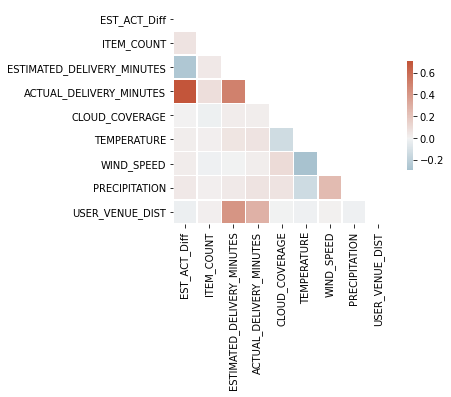

In [32]:
# Visualise correlation between variables of interest
corr = data[['EST_ACT_Diff', 'ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
       'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION',
       'USER_VENUE_DIST']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidth=0.5, 
                cbar_kws={"shrink":.5})

### 3) Visualising Correlations 
- The graph below is a visualization of the variables where is it even more evident that the variables are indeed mostly uncorrelated. Few variables

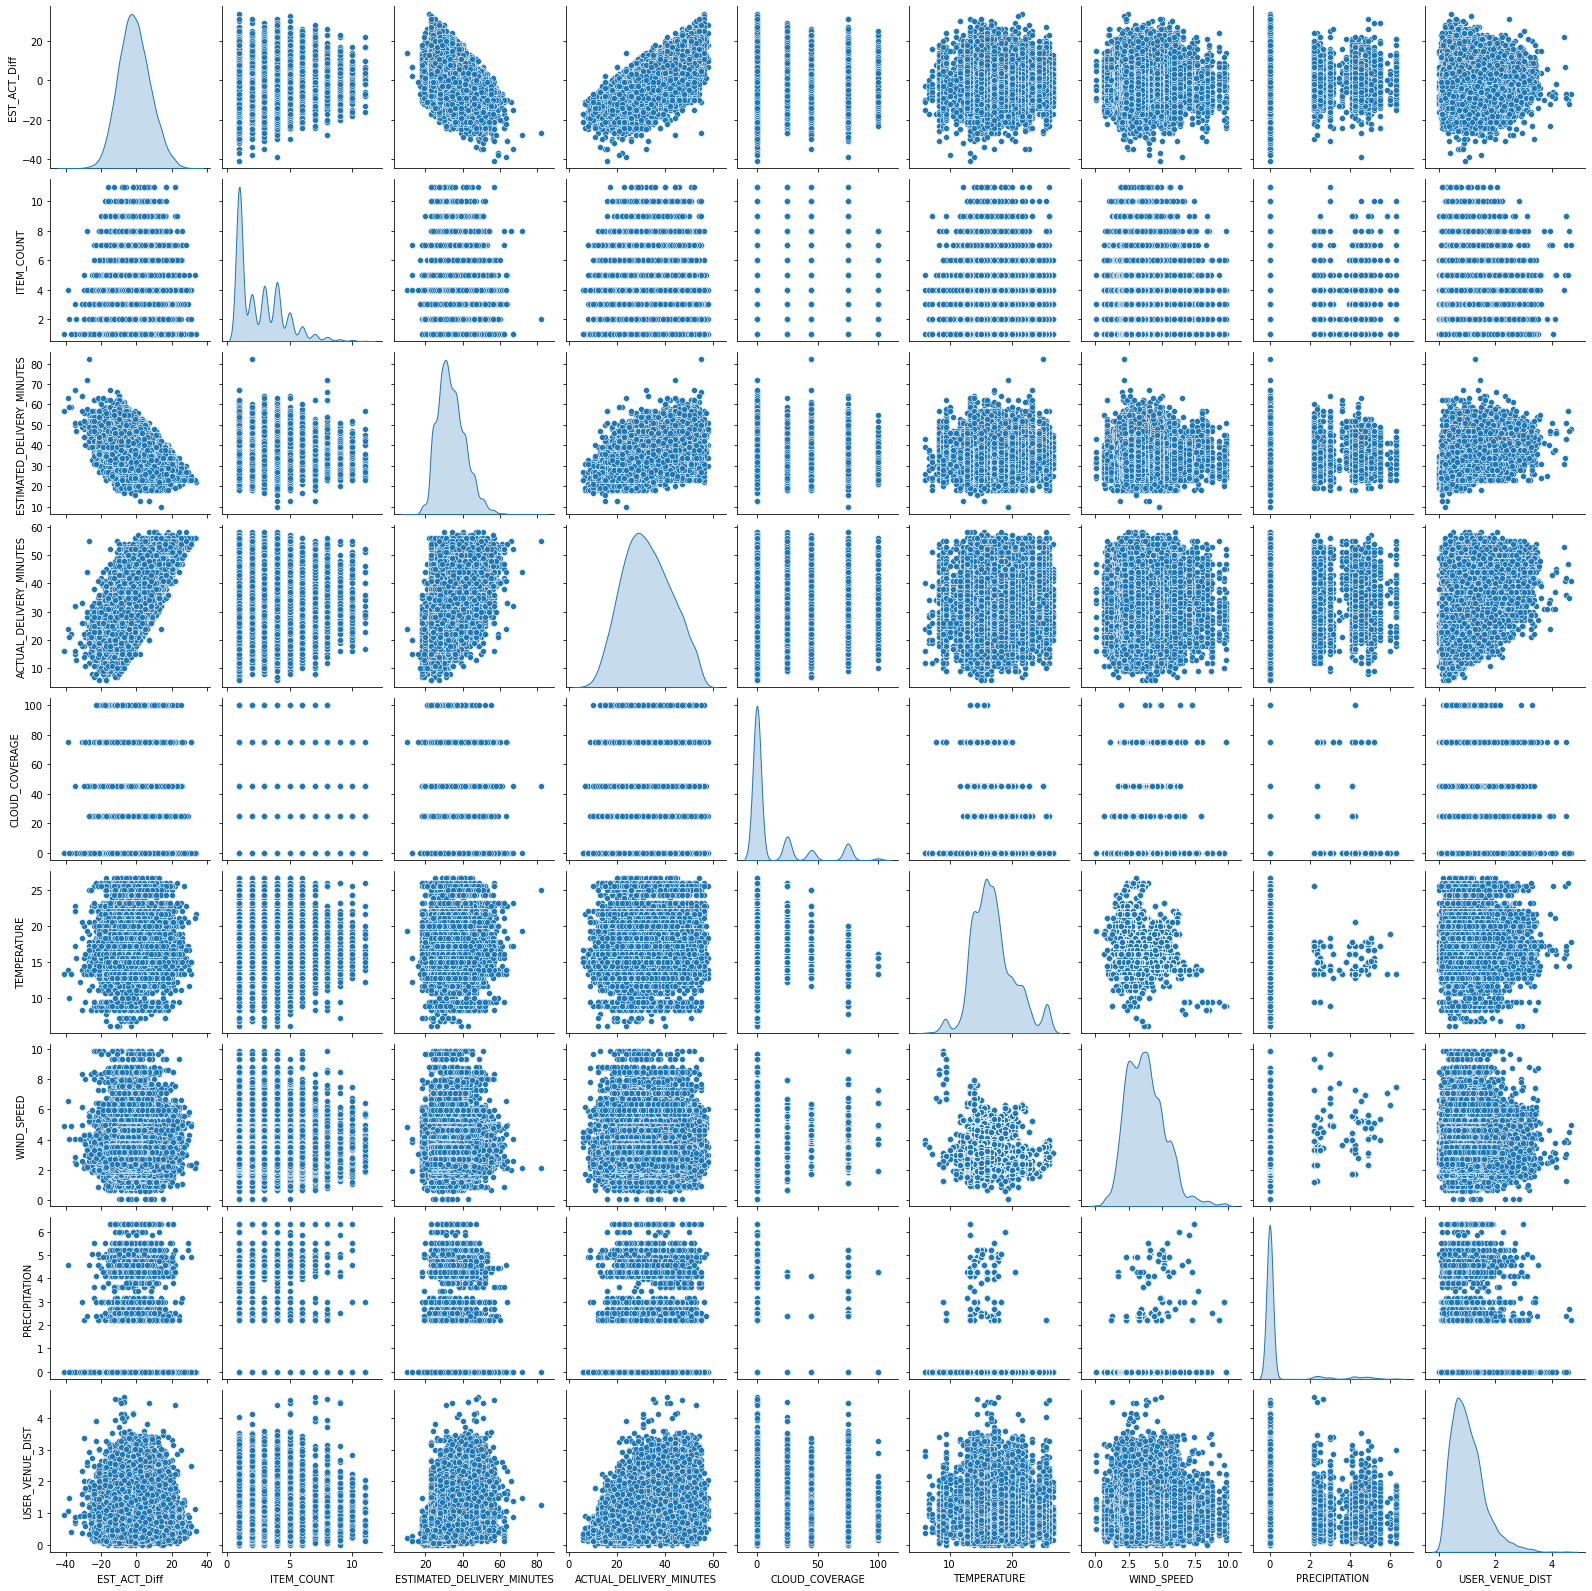

In [434]:
# Observe correlations between variables
_=sns.pairplot(data=data[['EST_ACT_Diff', 'ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 
                        'ACTUAL_DELIVERY_MINUTES', 'CLOUD_COVERAGE', 'TEMPERATURE',
                        'WIND_SPEED', 'PRECIPITATION','USER_VENUE_DIST']], diag_kind='kde')

### 3) Order Snapshot on a single day
This graph shows the distribution of the number of items on a single random day. The graph is consistent with the observations made about the larger group

<AxesSubplot:xlabel='ITEM_COUNT', ylabel='Count'>

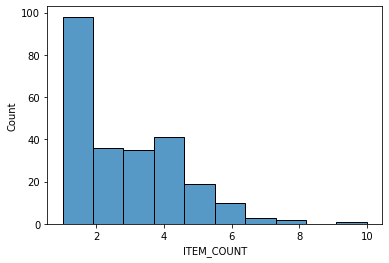

In [30]:
# Typical distributions of orders in a day
sns.histplot(data=data['ITEM_COUNT'].loc['08/20/2020'])

## Day of the week

### Background:
In this section, the main goal is explore the data on a Weekday basis

### Problem
Intuitively, it is expected that some days of the week may have a larger number of orders than others. If this is the case what is the actual disparity between orders between the weekdays.

### Solution
To investigate this issue, the we use the timestamps to identify the days of the week and assign each order the respective week day, followed by studying the distribution of orders across these days.

### Results
The graph below shows that Sundays and Saturdays followed by Friday are the most popular days with respect to orders. The days of week orders are also dominated by the same pattern such that orders with one item are most popular across all the days of the week while orders with a large number of items are few.

In [435]:
# Identify day of the week
# data['DayOfWeek'] = pd.Series(data.index, index=data.index).dt.day_name()

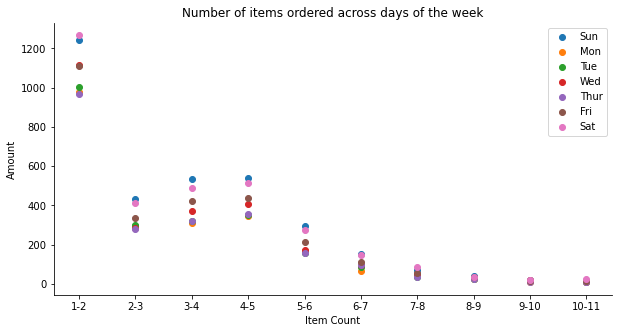

In [29]:
day_of_week_item_count = pd.DataFrame({'Sun':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Sunday'])[0],
                                       'Mon':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Monday'])[0],
                                       'Tue':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Tuesday'])[0],
                                       'Wed':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Wednesday'])[0],
                                       'Thur':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Thursday'])[0],
                                       'Fri':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Friday'])[0],
                                       'Sat':np.histogram(data['ITEM_COUNT'][data['DayOfWeek'] == 'Saturday'])[0]
                                     })
histindex = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11']
day_of_week_item_count.index=histindex

fig, ax = plt.subplots(figsize=(10,5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Amount')
ax.set_xlabel('Item Count')
ax.set_title('Number of items ordered across days of the week')
# ax.spines['left'].set_visible(False)
ax.plot(day_of_week_item_count['Sun'], 'o', label='Sun')
ax.plot(day_of_week_item_count['Mon'], 'o', label='Mon')
ax.plot(day_of_week_item_count['Tue'], 'o', label='Tue')
ax.plot(day_of_week_item_count['Wed'], 'o', label='Wed')
ax.plot(day_of_week_item_count['Thur'], 'o', label='Thur')
ax.plot(day_of_week_item_count['Fri'], 'o', label='Fri')
ax.plot(day_of_week_item_count['Sat'], 'o', label='Sat')
_=ax.legend()

## Orders Per Hour

### Background:
Orders per hour are an interesting feature to determine the nature of order flow during a given day.

### Problem
Understanding the flow of orders in a given day can be the basis of projecting the number of orders anticipated at a given time of the day.

### Solution
To explore this idea, we need to determing the number of orders that arrive in a given hour of the day. This is calculated based on the timestamp across the sample data.

### Result
The graphs below a snapshot of a random day (green curve) and snapshot of a random week (blue curve). The curves show the anticipated behaviour such that orders peak during lunch hours and go down as the evening sets in. The day-cycle is repeated every day and therefore leading to the cyclic weekly graph

<AxesSubplot:xlabel='TIMESTAMP'>

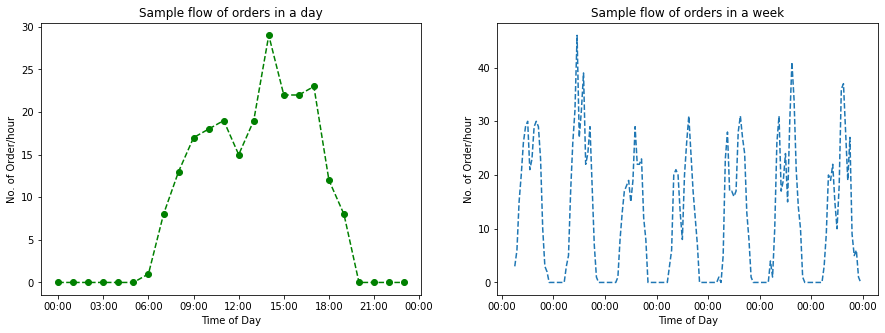

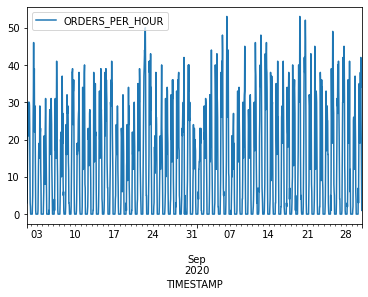

In [436]:
# Generate Hourly data

import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%H:%M')

orders_per_hour = data[['ITEM_COUNT']].resample('H').count()
orders_per_hour.rename(columns={'ITEM_COUNT':'ORDERS_PER_HOUR'}, inplace=True)
weather_per_hour = data[['TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']].resample('H').mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(orders_per_hour.loc['08/03/2020'], 'go--')
ax[0].set_ylabel('No. of Order/hour')
ax[0].set_xlabel('Time of Day')
ax[0].set_title('Sample flow of orders in a day')

ax[1].plot(orders_per_hour.loc['08/01/2020': '08/07/2020'], '--')
#ax[1].plot(weather_per_hour.loc['08/01/2020': '08/07/2020'], '--')

ax[1].set_ylabel('No. of Order/hour')
ax[1].set_xlabel('Time of Day')
ax[1].set_title('Sample flow of orders in a week')

ax[0].xaxis.set_major_formatter(fmt)
ax[1].xaxis.set_major_formatter(fmt)

orders_per_hour.plot()

(array([674, 100, 105, 156, 122, 113,  91,  67,  20,   7]),
 array([ 0. ,  5.3, 10.6, 15.9, 21.2, 26.5, 31.8, 37.1, 42.4, 47.7, 53. ]))

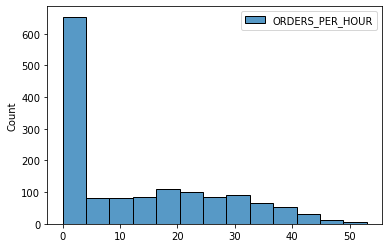

In [385]:
# distribution of orders in an hourly basis
sns.histplot(data=orders_per_hour.dropna())
np.histogram(orders_per_hour)

## Unique Users

### Background:
Given the user and venue coordinates, it would be possible to determine their respective orders and items

### Problem
How can the flow of orders be understood? Having orders mapped between users and venues would provide added insights into the flow of orders over the sample period

### Solution
This problem was solved by identifying unique user and venue coordinates and further mapping the respective item counts and total orders. One lattitude has multiple longitudes or vice versa. Matching these latlong values would identify unique users or venues

### Result
The table below shows a sample of unique user locations and total items orders from that location and the number of orders and the average delivery time to that given location.

In [555]:
# resdf = pd.DataFrame(results, columns=['Location', 'total_items', 'total_orders', 'avg_del_time'])
# resdf.head()

Location  total_items  total_orders  avg_del_time
0  (60.158, 24.946)           51            26     30.725000
1  (60.158, 24.935)          100            34     29.104938
2  (60.158, 24.922)           23             9     35.062500
3  (60.158, 24.915)           41            15     31.269231
4  (60.158, 24.952)           34            16     30.464286

In [437]:
# Identify unique users
# https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
# print(len(data['USER_LAT'].unique()), len(data['USER_LONG'].unique()))
data['USER_LAT'].unique()

array([60.158, 60.163, 60.161, 60.185, 60.182, 60.173, 60.188, 60.199,
       60.189, 60.154, 60.196, 60.178, 60.186, 60.183, 60.177, 60.162,
       60.159, 60.187, 60.181, 60.168, 60.171, 60.165, 60.184, 60.176,
       60.16 , 60.155, 60.197, 60.17 , 60.179, 60.174, 60.157, 60.164,
       60.195, 60.167, 60.175, 60.198, 60.194, 60.193, 60.169, 60.18 ,
       60.172, 60.156, 60.191, 60.19 , 60.2  , 60.166, 60.192, 60.153,
       60.201])

In [235]:
print(data['USER_LONG'][data['USER_LAT'] == 60.158].unique())
print(len(data['USER_LONG'][data['USER_LAT'] == 60.158].unique()), 'unique locations in that lat')

[24.946 24.935 24.922 24.915 24.952 24.937 24.916 24.921 24.938 24.931
 24.919 24.936 24.93  24.941 24.934 24.956 24.943 24.944 24.945 24.92
 24.942 24.948 24.949 24.932 24.955 24.951 24.912 24.94  24.933 24.914
 24.939 24.947 24.909 24.918 24.917 24.953 24.961 24.913 24.95  24.911
 24.958 24.96  24.959 24.91  24.954]
45 unique locations in that lat


In [536]:
# Find unique USER addresses, their number of orders and total items ordered over the sample period
# It seems users are consumers while Venue refer to restaurants
# After data processing, this computation is not needed since the data is properly locally stored
results = list()
for lat in data['USER_LAT'].unique():
    locations = data['USER_LONG'][data['USER_LAT']==lat].unique()
    for long in locations:
        total_items = data['ITEM_COUNT'][(data['USER_LONG']==long) & (data['USER_LAT']==lat)].resample('D').sum()
        total_orders = data['ITEM_COUNT'][(data['USER_LONG']==long) & (data['USER_LAT']==lat)].resample('D').count()
        avg_del_time = data['ACTUAL_DELIVERY_MINUTES'][(data['USER_LONG']==long) & (data['USER_LAT']==lat)].resample('D').mean()
        results.append(((lat, long,), total_items.sum(), total_orders.sum(), avg_del_time.mean()))

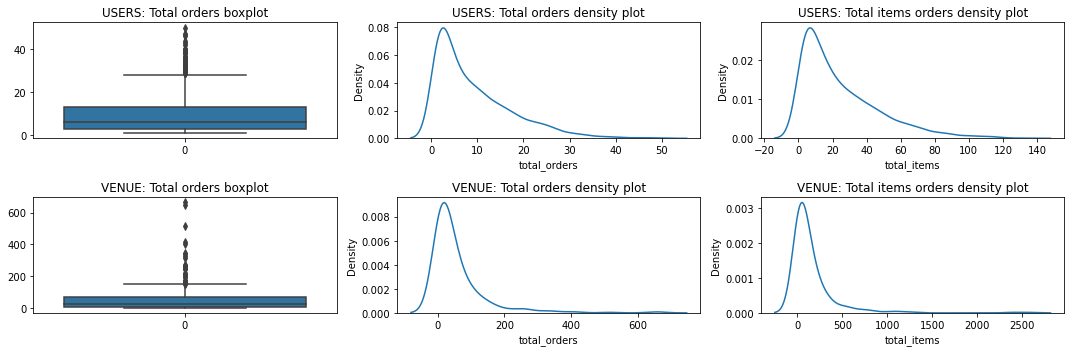

In [108]:
# Total orders and total items orders over the sample period

u_totalorders = data[['user_coordinates','ITEM_COUNT']].groupby('user_coordinates').count().sort_values('ITEM_COUNT')
u_totalitems = data[['user_coordinates','ITEM_COUNT']].groupby('user_coordinates').sum().sort_values('ITEM_COUNT')
u_orders_items = u_totalorders.copy().rename(columns={'ITEM_COUNT':'total_orders'})
u_orders_items['total_items'] = u_totalitems

v_totalorders = data[['venue_coordinates','ITEM_COUNT']].groupby('venue_coordinates').count().sort_values('ITEM_COUNT')
v_totalitems = data[['venue_coordinates','ITEM_COUNT']].groupby('venue_coordinates').sum().sort_values('ITEM_COUNT')
v_orders_items = v_totalorders.copy().rename(columns={'ITEM_COUNT':'total_orders'})
v_orders_items['total_items'] = v_totalitems

fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0,0].set_title("USERS: Total orders boxplot")
ax[0,1].set_title("USERS: Total orders density plot")
ax[0,2].set_title("USERS: Total items orders density plot")

_=sns.boxplot(data=u_orders_items['total_orders'], ax=ax[0,0])
_=sns.kdeplot(data=u_orders_items['total_orders'], ax=ax[0,1])
_=sns.kdeplot(data=u_orders_items['total_items'], ax=ax[0,2])

ax[1,0].set_title("VENUE: Total orders boxplot")
ax[1,1].set_title("VENUE: Total orders density plot")
ax[1,2].set_title("VENUE: Total items orders density plot")

_=sns.boxplot(data=v_orders_items['total_orders'], ax=ax[1,0])
_=sns.kdeplot(data=v_orders_items['total_orders'], ax=ax[1,1])
_=sns.kdeplot(data=v_orders_items['total_items'], ax=ax[1,2])
fig.tight_layout()

In [96]:
# Get quantiles of USER and VENUE Total Orders and Total Items
q_uo = np.quantile(u_orders_items['total_orders'], [0.25, 0.5, 0.75])
min_uo = 1-1.5*(q_uo[2]-q_uo[0])
max_uo = 1+1.5*(q_uo[2]-q_uo[0])
q_ui = np.quantile(u_orders_items['total_items'], [0.25, 0.5, 0.75])
min_ui = 1-1.5*(q_ui[2]-q_ui[0])
max_ui = 1+1.5*(q_ui[2]-q_ui[0])

q_vo = np.quantile(v_orders_items['total_orders'], [0.25, 0.5, 0.75])
min_vo = 1-1.5*(q_vo[2]-q_vo[0])
max_vo = 1+1.5*(q_vo[2]-q_vo[0])
q_vi = np.quantile(u_orders_items['total_items'], [0.25, 0.5, 0.75])
min_vi = 1-1.5*(q_vi[2]-q_vi[0])
max_vi = 1+1.5*(q_vi[2]-q_vi[0])

def assign_class_orders(val, **kwargs):
    print
    if val < kwargs['min_']:
        return '<min'.format(kwargs['min_'])
    elif((val > kwargs['min_']) & (val <= kwargs['q'][0])):
        return '<25%'.format(kwargs['q'][0])
    elif((val > kwargs['q'][0]) & (val <= kwargs['q'][2])):
        return '>25% & <75%'.format(kwargs['q'][0], kwargs['q'][2])
    elif((val > kwargs['q'][2]) & (val <= kwargs['max_'])):
        return '>75% & <max'.format(kwargs['q'][2], kwargs['max_'])
    elif(val > kwargs['max_']):
        return '>max'.format(kwargs['max_'])

u_orders_items['orders'] = u_orders_items['total_orders'].apply(assign_class_orders, q=q_uo, min_=min_uo, max_=max_uo)
u_orders_items['items'] = u_orders_items['total_items'].apply(assign_class_orders, q=q_ui, min_=min_ui, max_=max_ui)

v_orders_items['orders'] = v_orders_items['total_orders'].apply(assign_class_orders, q=q_vi, min_=min_vo, max_=max_vo)
v_orders_items['items'] = v_orders_items['total_items'].apply(assign_class_orders, q=q_vi, min_=min_vi, max_=max_vi)


In [94]:
# u_orders_items.head()

total_orders  total_items orders items
user_coordinates                                        
(60.153, 24.91)              1            4   <25%  <25%
(60.176, 24.914)             1            5   <25%  <25%
(60.176, 24.912)             1            4   <25%  <25%
(60.175, 24.963)             1            6   <25%  <25%
(60.175, 24.962)             1            3   <25%  <25%

### Outliers among USERs and VENUEs
These plots below are meant to identify the relationship between the total number of orders and the total number of items between USERS(left) and VENUES(right). The colour coding is based on the respective percentiles. Outliers in the VENUES are indicative of venues are highly popular compared to the rest.

<min:0, <25%:662, >25%&<75%:875, >75%&<max:152, >max:356


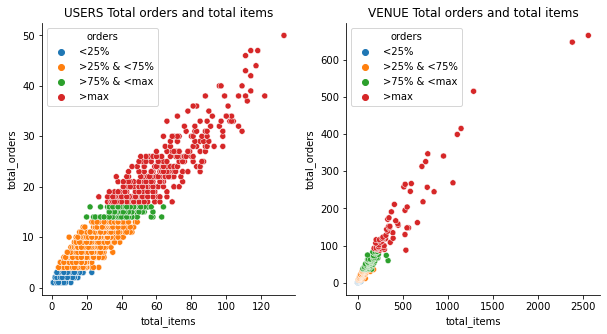

In [97]:
# Plot scatter plots of total orders vs total items ordered based on users and venue
print('<min:{}, <25%:{}, >25%&<75%:{}, >75%&<max:{}, >max:{}'.format(
    sum(u_orders_items['orders']=='<min'), sum(u_orders_items['orders']=='<25%'),
    sum(u_orders_items['orders']=='>25% & <75%'), sum(u_orders_items['orders']=='>75% & <max'),
    sum(u_orders_items['orders']=='>max')))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("USERS Total orders and total items")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
_ = sns.scatterplot(data=u_orders_items, x='total_items', y='total_orders', hue='orders', ax=ax[0])

ax[1].set_title("VENUE Total orders and total items")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
_ = sns.scatterplot(data=v_orders_items, x='total_items', y='total_orders', hue='orders', ax=ax[1])

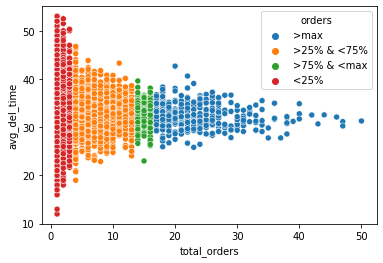

In [569]:
# Delivery time and number of orders (Number of orders and Delivery minutes)
# Delivery time and number of items (Item count vs Delivery minutes)
_ = sns.scatterplot(data=resdf, x='total_orders', y='avg_del_time', hue='orders')

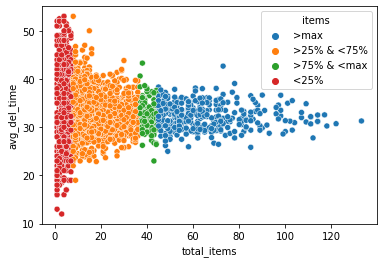

In [570]:
# Orders with multiple items and delivery times
# Orders and Delivery Times
_ = sns.scatterplot(data=resdf, x='total_items', y='avg_del_time', hue='items')

## Regressions

### Background:
One of the key goals of this exercise was to set up a prediction model using the dataset provided.

### Problem
What kind of prediction model can be developed using the given data? Can orders be predicted ? Predicting orders could help in improving efficiency between between users and venues.

### Solution
This section focused on predicting the number of orders obtained, this was done using a variety of strategies. 
- A linear regression model
- A linear regression with dummy variables
- A regression tree model
- An ARMA model (timeseries model)

These models were selected to cover linear approach, non-linear and auto correlation based model

### Result
The results of this approaches are presented in the graph below. The best performing model being the ARIMA model

#### Modelling Tuning Approach
All models were cross-validated as shown in the cells below.

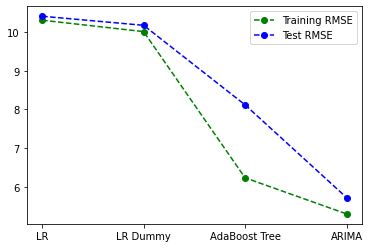

In [440]:
summary_rmse[0,:] = rmse[0,:,:].mean(axis=0)
summary_rmse[1,:] = rmse[1,:,:].mean(axis=0)
summary_rmse[2,:] = rmse[2,:,:].mean(axis=0)
summary_rmse[3,:] = arima_mse.mean(axis=0)
fig, ax = plt.subplots()
index = ['LR', 'LR Dummy', 'AdaBoost Tree', 'ARIMA']
plt_df = pd.DataFrame(data=summary_rmse, index=index, columns=['Train RMSE', 'Test RMSE'])
ax.plot(plt_df['Train RMSE'], 'go--', label='Training RMSE')
ax.plot(plt_df['Test RMSE'], 'bo--', label='Test RMSE')
_=ax.legend()

In [98]:
data.columns

Index(['EST_ACT_Diff', 'ITEM_COUNT', 'USER_LAT', 'USER_LONG', 'VENUE_LAT',
       'VENUE_LONG', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
       'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION',
       'USER_VENUE_DIST', 'DayOfWeek', 'user_coordinates', 'venue_coordinates',
       'venue_postal_code', 'user_postal_code', 'source_of_order_pcode'],
      dtype='object')

In [172]:
# Create data for a general linear regression
reg_data = data[['EST_ACT_Diff', 'ITEM_COUNT','ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
                 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION',
                 'USER_VENUE_DIST', 'DayOfWeek']].resample('H').mean()

reg_data['DayOfWeek'] = pd.Series(reg_data.index, index=reg_data.index).dt.day_name()
reg_data['orders_per_hour'] = orders_per_hour
reg_data.dropna(inplace=True)
X = reg_data.drop(columns=['DayOfWeek', 'orders_per_hour']).values
y = reg_data['orders_per_hour'].values

In [183]:
# Create dummy variables for a linear regression model with dummy variables
dummy = reg_data[['DayOfWeek']].copy()
for day in ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
    dummy[day] = np.zeros(reg_data.shape[0])
    mask = reg_data['DayOfWeek'] == day
    dummy.loc[mask, day] = 1

X_dummy = reg_data.drop(columns=['DayOfWeek', 'orders_per_hour']).join(dummy.drop(columns=['DayOfWeek'])).values

In [206]:
# Find a reasonable Boosted tree estimator
parameter_grid = {'criterion': ['mse', 'friedman_mse'], 
                  'max_depth': [3, 5, 10], 
                  'max_features': ['auto', 'sqrt', 'log2', None]
                 }
tree_reg = DecisionTreeRegressor(random_state=1)
grid_search = GridSearchCV(estimator=tree_reg, param_grid=parameter_grid, cv=10, 
                        n_jobs=-1, verbose=0, return_train_score=True)
grid_search.fit(X, y)

random_search = RandomizedSearchCV(estimator=tree_reg, param_distributions=parameter_grid, cv=10, 
                        n_jobs=-1, verbose=0, return_train_score=True)
random_search.fit(X, y)

print(grid_search.best_params_)
print(random_search.best_params_)

{'criterion': 'mse', 'max_depth': 5, 'max_features': 'sqrt'}
{'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'friedman_mse'}


In [246]:
# Simulate ARIMA model

def seasonal_arima_simulation(data, s, start_date='06/01/2017', **kwargs):
    """
    Runs tests to identify suitable model parameters for a seasonal
    arima model by printing out the AIC values, over multiple
    variations of a model, the model with the lowest AIC value is
    considered to be the most optimal model.

    In order to create a forecasting seasonal ARIMA model, we need to
    select the most optimum model which is based on picking the model
    with the the lowest AIC value

    data: the data to be analysed
    start_date: the begin of testing a prediction model
    """
    from warnings import filterwarnings
    filterwarnings("ignore")
    result = list()

    # Generate combinations of various (p, d, q) parameters to simulate
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    pdq_seasonal = [(x[0], x[1], x[2], s) for x in pdq]
    
    for orderARIMA in pdq:
        print(orderARIMA, s)
        for seasonalARIMA in pdq_seasonal:
            try:
                model = sm.tsa.statespace.SARIMAX(data, order=orderARIMA, seasonal_order=seasonalARIMA, 
                                                  enforce_stationarity=False, enforce_invertibility=False, trend=None)
                # print(orderARIMA, seasonalARIMA)
                res = model.fit()
                pred = res.get_prediction() # start=start_date
                pred_values = pred.predicted_mean
                mae = mean_absolute_error(data, pred_values)
                mse = mean_squared_error(data, pred_values)
                rmse = np.sqrt(mse)
                result.append((orderARIMA, seasonalARIMA, res.aic, res.bic, mae, mse, rmse))
            except:
                print("An error occurred: ", sys.exc_info()[0])
    df = pd.DataFrame(result, columns=['ARIMA Order', 'Seasonal Order', 'AIC', 'BIC', 'MAE', 'MSE', 'RMSE'])
    df.sort_values('AIC', inplace=True)
    return df

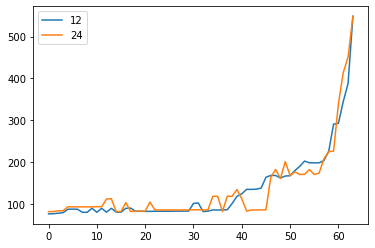

In [237]:
# Try different seasonality approaches, seems indifferent
plt.plot(arima_12['MSE'].values, label='12')
plt.plot(arima_24['MSE'].values, label='24')
plt.legend()

In [317]:
arima_24.head()

ARIMA Order Seasonal Order          AIC          BIC       MAE        MSE  \
43   (1, 0, 1)  (0, 1, 1, 24)  6303.340766  6322.442230  7.176167  81.180348   
47   (1, 0, 1)  (1, 1, 1, 24)  6305.143030  6329.019861  7.174650  81.176991   
35   (1, 0, 0)  (0, 1, 1, 24)  6345.559159  6359.888680  7.287050  83.166261   
39   (1, 0, 0)  (1, 1, 1, 24)  6347.418925  6366.524953  7.286015  83.161710   
27   (0, 1, 1)  (0, 1, 1, 24)  6455.346559  6469.669230  7.588868  92.590017   

        RMSE  
43  9.010014  
47  9.009827  
35  9.119554  
39  9.119304  
27  9.622371

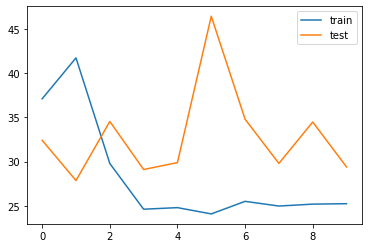

In [316]:
# Studying the train and test errors of the ARIMA model
y_arima = orders_per_hour # reg_data['orders_per_hour'] 
tscv = TimeSeriesSplit(n_splits=10)
arima_mse=np.zeros((10,2))
for j, (train_ind, test_ind) in enumerate(tscv.split(y_arima)):
    Ytrain, Ytest = y_arima.iloc[train_ind], y_arima.iloc[test_ind]
    model = sm.tsa.statespace.SARIMAX(Ytrain, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24), 
                                      enforce_stationarity=False, enforce_invertibility=False, trend=None)
    arima_model = model.fit()
    y_pred = arima_model.get_prediction().predicted_mean #train
    y_forecast = arima_model.forecast(steps=len(Ytest.index)) # test
    arima_mse[j,0] = mean_squared_error(Ytrain, y_pred) # train
    arima_mse[j,1] = mean_squared_error(Ytest, y_forecast) # test

plt.plot(arima_mse[:,0], label='train')
plt.plot(arima_mse[:,1], label='test')
plt.legend()

In [325]:
# CV regressions
#kf_cv = KFold(n_splits=10, shuffle=True, random_state=1)
rcv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
rng = np.random.RandomState(1)

rmse = np.zeros((3, 100, 2)) # models, cvs, train/test
arima_mse=np.zeros((10,2))
summary_rmse = np.zeros((4, 2))

lr = LinearRegression()
xg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, criterion='friedman_mse', max_features='sqrt'), n_estimators=300, random_state=rng)

print('Fitting Normal linear Regression')
for j, (train_ind, test_ind) in enumerate(rcv.split(X)): # Linear Reg
    X_train, Y_train = X[train_ind], y[train_ind]
    X_test, Y_test = X[test_ind], y[test_ind]
    model = lr.fit(X_train, Y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse[0, j, 0] = np.sqrt(mean_squared_error(Y_train, y_pred_train)) # train
    rmse[0, j, 1] = np.sqrt(mean_squared_error(Y_test, y_pred_test)) # test
print('Fitting linear regression with dummy variables')
for j, (train_ind, test_ind) in enumerate(rcv.split(X_dummy)): # Linear Reg with dummy variables
    X_train, Y_train = X_dummy[train_ind], y[train_ind]
    X_test, Y_test = X_dummy[test_ind], y[test_ind]
    model = lr.fit(X_train, Y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse[1, j, 0] = np.sqrt(mean_squared_error(Y_train, y_pred_train))
    rmse[1, j, 1] = np.sqrt(mean_squared_error(Y_test, y_pred_test))

print('Fitting a boosted Tree')
for j, (train_ind, test_ind) in enumerate(rcv.split(X)):
    X_train, Y_train = x[train_ind], y[train_ind]
    X_test, Y_test = x[test_ind], y[test_ind]
    model = xg.fit(X_train, Y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse[2, j, 0] = np.sqrt(mean_squared_error(Y_train, y_pred_train))
    rmse[2, j, 1] = np.sqrt(mean_squared_error(Y_test, y_pred_test))

Fitting Normal linear Regression
Fitting linear regression with dummy variables
Fitting a boosted Tree
Fitting an ARIMA model


In [360]:
print('Fitting an ARIMA model')
y_arima =  orders_per_hour #reg_data['orders_per_hour']
tscv = TimeSeriesSplit(n_splits=10)
for j, (train_ind, test_ind) in enumerate(tscv.split(y_arima)):
    Ytrain, Ytest = y_arima.iloc[train_ind], y_arima.iloc[test_ind]
    model_ar = sm.tsa.statespace.SARIMAX(Ytrain, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24),
                                            enforce_stationarity=False, enforce_invertibility=False, trend=None)
    arima_model = model_ar.fit()
    y_pred = arima_model.get_prediction().predicted_mean #train
    y_forecast = arima_model.forecast(steps=len(Ytest.index)) # test
    arima_mse[j,0] = np.sqrt(mean_squared_error(Ytrain, y_pred)) # train
    arima_mse[j,1] = np.sqrt(mean_squared_error(Ytest, y_forecast)) # test

Fitting an ARIMA model


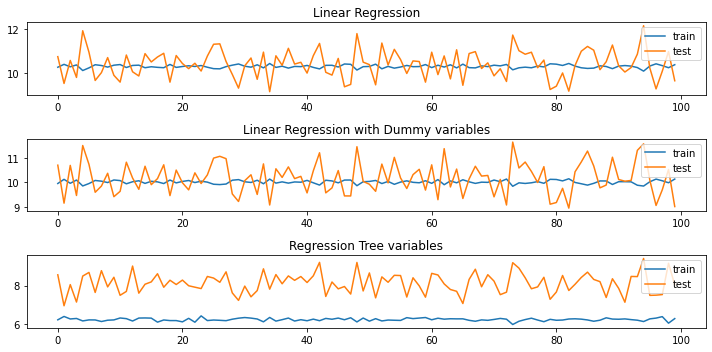

In [494]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(rmse[0,:,0], label='train')
# ax.plot(rmse[0,:,1], label='test')
# ax.set_title('Linear Regression')
# ax.legend()

fig, ax = plt.subplots(3, figsize=(10, 5))
ax[0].plot(rmse[0,:,0], label='train')
ax[0].plot(rmse[0,:,1], label='test')
ax[0].set_title('Linear Regression')
ax[0].legend()

ax[1].plot(rmse[1,:,0], label='train')
ax[1].plot(rmse[1,:,1], label='test')
ax[1].set_title('Linear Regression with Dummy variables')
ax[1].legend()

ax[2].plot(rmse[2,:,0], label='train')
ax[2].plot(rmse[2,:,1], label='test')
ax[2].set_title('Regression Tree variables')
ax[2].legend()

fig.tight_layout()

[[10.31183703 10.41491469]
 [10.0168755  10.17992385]
 [ 6.22930329  8.11979202]
 [ 5.29420742  5.71759328]]


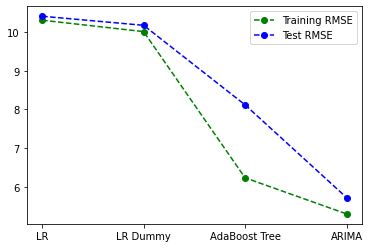

In [361]:
summary_rmse[0,:] = rmse[0,:,:].mean(axis=0)
summary_rmse[1,:] = rmse[1,:,:].mean(axis=0)
summary_rmse[2,:] = rmse[2,:,:].mean(axis=0)
summary_rmse[3,:] = arima_mse.mean(axis=0)
print(summary_rmse)
fig, ax = plt.subplots()
index = ['LR', 'LR Dummy', 'AdaBoost Tree', 'ARIMA']
plt_df = pd.DataFrame(data=summary_rmse, index=index, columns=['Train RMSE', 'Test RMSE'])
ax.plot(plt_df['Train RMSE'], 'go--', label='Training RMSE')
ax.plot(plt_df['Test RMSE'], 'bo--', label='Test RMSE')
ax.legend()

## Testing Regression Model

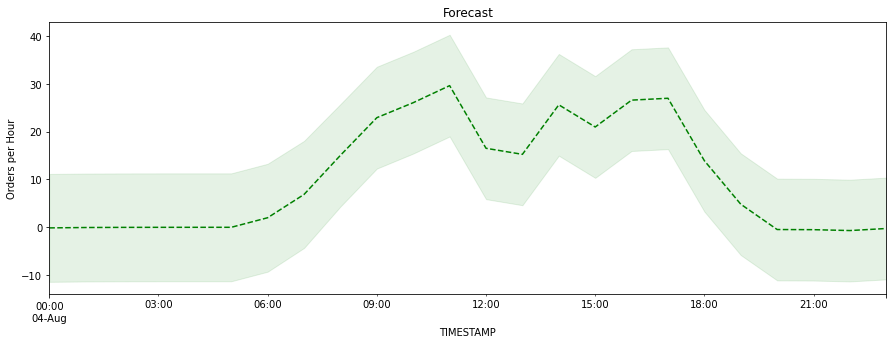

In [490]:
X = reg_data.drop(columns=['DayOfWeek', 'orders_per_hour']).values
Y = reg_data['orders_per_hour'].values
    
# model = sm.tsa.statespace.SARIMAX(Ytrain, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24), 
#                                   enforce_stationarity=False, enforce_invertibility=False, trend=None)
# arima_model = model.fit()
pred_ = arima_model.get_prediction()
y_pred = pred_.predicted_mean
predict_ci = pred_.conf_int()
#y_forecast = arima_model.forecast(steps=len(Ytest.index)) # test

fig, ax = plt.subplots(figsize=(15,5))
ax.set(title='Forecast', xlabel='Date', ylabel='Orders per Hour')
y_pred.loc['08/04/2020'].plot(ax=ax, style='g--', label='One-step-ahead forecast')
ci = predict_ci.loc['08/04/2020']
ax.fill_between(predict_ci.loc['08/04/2020'].index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)


In [478]:
y_pred

TIMESTAMP
2020-08-01 06:00:00     0.000000
2020-08-01 07:00:00     1.116508
2020-08-01 08:00:00     2.869656
2020-08-01 09:00:00     7.257599
2020-08-01 10:00:00    10.788427
                         ...    
2020-09-10 11:00:00    21.350873
2020-09-10 12:00:00    17.488705
2020-09-10 13:00:00    21.497334
2020-09-10 14:00:00    26.868901
2020-09-10 15:00:00    30.785859
Freq: H, Name: predicted_mean, Length: 970, dtype: float64

# Classification

### Background:
In this section, the ideas is to come up with a classification problem.

### Problem
Experimenting with the data as shown in the Experimental section below indicates that some postcode zones are quite active compared to others. A classification problem has been setup to determine whether an order will be headed out of the zone or will be within the zone. This could allow assigning of the fasted means of transport and the most efficient.

### Solution
Assign each order to a postal code, this was facilitated by calling  Google maps reverse geoding API which allowed estimated of a location's postal code. Both a user and a venue are assigned a postal code, if both postal codes do not match, the order is considered to OUT bound otherwise IN bound when the postal codes match.

A Logistic Regression and Support Vector Machine (SVM) were tested for this task. Both models produce almost similar results (81%-82%) although the SVM model was not subjected to a high number of cross validations due to performance issues.

In [405]:
# Helper functions to generate address and postal codes
config = ConfigParser()
config.read('config.ini')
API_KEY = config['googlemaps']['api_key']
gmaps = googlemaps.Client(key=API_KEY)

def get_street_address(val):
    """
    A helper function to compute the postal address.
    
    This function makes use of the googlemap library that 
    queries the reversegeocode API from google's Map API.
    Multiple results may be returned but only one is needed
    to compute know the postal code
    """
    reverse_geocode_result = gmaps.reverse_geocode(val, result_type='street_address')
    if len(reverse_geocode_result) > 0:
        return reverse_geocode_result[0]['formatted_address']
    else:
        return None

def process_address_str(val):
    if val == None:
        return None
    else:
        postal_code_city = val.split(',')[1]
        if len(postal_code_city.split()) > 1:
            return postal_code_city.split()[0]
        else:
            return None

In [386]:
# Classification Data
cl_data = data[['EST_ACT_Diff', 'ITEM_COUNT', 'ESTIMATED_DELIVERY_MINUTES', 
                'ACTUAL_DELIVERY_MINUTES','CLOUD_COVERAGE', 'TEMPERATURE', 
                'WIND_SPEED', 'PRECIPITATION','USER_VENUE_DIST', 'source_of_order_pcode']]
cl_data = cl_data.dropna()
X_cl = scale(cl_data.drop(columns=['source_of_order_pcode']))
Y_cl = cl_data['source_of_order_pcode']

Fitting Logistic Logression model
Fitting SVM model


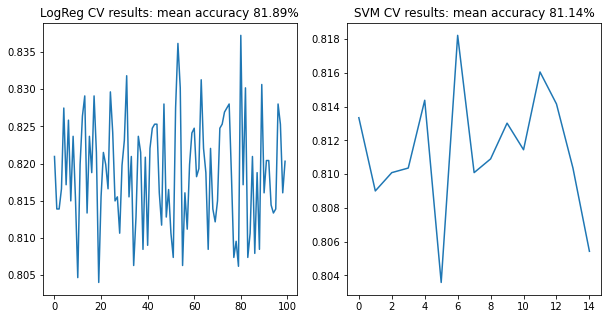

In [426]:
rcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
lr_cl = LogisticRegression()
svm_cl = svm.SVC(probability=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

print('Fitting Logistic Logression model')
acc_scores_logR = cross_val_score(lr_cl, X_cl, Y_cl, scoring='accuracy', cv=rcv, n_jobs=-1)
ax[0].plot(acc_scores_logR, label='CV')
_=ax[0].set_title('LogReg CV results: mean accuracy {:.2%}'.format(np.mean(acc_scores_logR)))

# Reduce the repetitions and splits for performance
print('Fitting SVM model')
svm_rcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
acc_scores_svm = cross_val_score(svm_cl, X_cl, Y_cl, scoring='accuracy', cv=svm_rcv, n_jobs=-1)
ax[1].plot(acc_scores_svm, label='CV')
_=ax[1].set_title('SVM CV results: mean accuracy {:.2%}'.format(np.mean(acc_scores_svm)))

fig.tight_layout()

## Testing Classification Results
The experiment below shows results are consistent with the cross validation results. With resonable accuracy, it is possible to predict direction an order is headed. The logistic regression model performs better compared to SVM model.

In [429]:
X = cl_data.drop(columns=['source_of_order_pcode'])
Y = cl_data['source_of_order_pcode']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=24)
model_lr = lr_cl.fit(X_train, Y_train)
ypred_train = model_lr.predict(X_train)
ypred_test = model_lr.predict(X_test)
print('LogReg. Accuracy {:.2%}'.format(accuracy_score(Y_train, ypred_train, normalize=True)))
print('LogReg. Accuracy {:.2%}'.format(accuracy_score(Y_test, ypred_test, normalize=True)))

model_svm = svm_cl.fit(X_train, Y_train)
ypred_train = model_svm.predict(X_train)
ypred_test = model_svm.predict(X_test)

print('SVM Accuracy {:.2%}'.format(accuracy_score(Y_train, ypred_train, normalize=True)))
print('SVM. Accuracy {:.2%}'.format(accuracy_score(Y_test, ypred_test, normalize=True)))

LogReg. Accuracy 81.99%
LogReg. Accuracy 81.86%
SVM Accuracy 78.79%
SVM. Accuracy 77.57%


# Experimental Stuff

### Background:
This section is highly experimental ideas and an extra sandbox

### Problem
There were many other ideas that come up as analysis continues, for example the number of orders that come out of a given zone is calculated among other concepts.

### Solution
N/A

In [667]:
resdf[['total_items', 'total_orders', 'postal_codes']].groupby('postal_codes').sum()

total_items  total_orders
postal_codes                           
00099                   1             1
00100                6779          2499
00101                 205            84
00120                2189           809
00130                 841           285
00140                2815          1037
00150                4279          1591
00160                1517           534
00170                2496           879
00180                3709          1350
00220                2268           813
00240                 410           138
00250                2963          1186
00260                1509           550
00270                  68            26
00290                  97            31
00360                  43            18
00500                3429          1348
00510                3499          1317
00520                1312           477
00530                6014          2292
00540                 651           229
00550                1888           700
00580                 881           357

In [671]:
postal_codes_entities = resdf['postal_codes'].value_counts()

In [702]:
postal_codes_entities

00100    255
00530    176
00510    149
00250    138
00180    133
00550    116
00150    114
00170    103
00160     96
00140     95
00500     84
00220     82
00580     74
00520     73
00260     72
00120     57
00540     55
00130     48
00240     43
00270      9
00290      9
00101      9
00099      1
00360      1
Name: postal_codes, dtype: int64

In [685]:
unique_venues = pd.Series(data['venue_coordinates'].unique())

In [689]:
venue_addresses = unique_venues.map(get_street_address)

In [693]:
resdf_venue = pd.DataFrame({'venue_coordinates':unique_venues, 'venue_addresses':venue_addresses})

In [695]:
resdf_venue['venue_postal_code'] = resdf_venue['venue_addresses'].map(process_address_str)

In [703]:
resdf_venue

venue_coordinates                                venue_addresses  \
0     (60.16, 24.946)      Jägaregatan 2, 00140 Helsingfors, Finland   
1     (60.153, 24.91)       Atlantinkatu 18, 00220 Helsinki, Finland   
2    (60.162, 24.939)  Iso Roobertinkatu 38, 00120 Helsinki, Finland   
3     (60.19, 24.911)   Topeliusgatan 30, 00290 Helsingfors, Finland   
4    (60.178, 24.949)     Paasivuorenkatu 2, 00530 Helsinki, Finland   
..                ...                                            ...   
326  (60.159, 24.938)          Sepänkatu 13, 00150 Helsinki, Finland   
327   (60.188, 24.98)     Kalasatamankatu 2, 00580 Helsinki, Finland   
328  (60.191, 24.943)    Viborgsgatan 14, 00510 Helsingfors, Finland   
329  (60.158, 24.946)     Kaptensgatan 9, 00140 Helsingfors, Finland   
330  (60.198, 24.926)         Böletået 7, 00240 Helsingfors, Finland   

    venue_postal_code  
0               00140  
1               00220  
2               00120  
3               00290  
4               00530  
..                ...  
326             00150  
327             00580  
328             00510  
329             00140  
330             00240  

[331 rows x 3 columns]

In [707]:
len(resdf_venue['venue_postal_code'].unique())

33

In [711]:
resdf_venue['venue_postal_code'].value_counts()

00100    71
00180    26
00530    25
00500    24
00510    21
00120    18
00150    15
00250    13
00260    13
00130    10
00220     9
00580     8
00170     8
00140     8
00520     7
00160     6
00540     6
00560     5
00240     5
00810     4
00210     4
00550     3
00270     3
00290     2
00101     2
00200     2
00610     2
00330     2
00350     2
00620     1
00570     1
00320     1
Name: venue_postal_code, dtype: int64

In [771]:
# Create dict for venue postal codes
venue_coord_pcode_dict = resdf_venue.set_index('venue_coordinates')['venue_postal_code'].to_dict()

# Create dict for User postal codes
user_coord_pcode_dict = resdf.set_index('Location')['postal_codes'].to_dict()

# Generate a venue dictionary to facilitate look up of postal code
def assign_venue_postal_code(val):
    return venue_coord_pcode_dict[val]

def assign_user_postal_code(val):
    return user_coord_pcode_dict[val]

res = data['venue_coordinates'].map(assign_venue_postal_code)
data['venue_postal_code'] = res
data['user_postal_code'] = data['user_coordinates'].map(assign_user_postal_code)

In [783]:
venue_pcode_dist = data['venue_postal_code'].value_counts()

In [784]:
user_pcode_dist = data['user_postal_code'].value_counts()

In [798]:
venue_pcode_dist

00100    6128
00500    1883
00530    1848
00120    1502
00510    1267
00180    1058
00260     881
00250     737
00520     447
00540     412
00170     346
00550     339
00150     313
00220     299
00140     234
00130     209
00580     187
00240     128
00160      80
00290      80
00270      62
00101      56
00610      52
00560      19
00200      13
00210       9
00810       5
00570       5
00350       5
00330       2
00620       1
00320       1
Name: venue_postal_code, dtype: int64

In [811]:
#temp = pd.DataFrame(index=data.index)
data[['venue_postal_code', 'user_postal_code']]

venue_postal_code user_postal_code
TIMESTAMP                                             
2020-08-01 06:07:00             00140            00140
2020-08-01 06:17:00             00220            00180
2020-08-01 06:54:00             00120            00120
2020-08-01 07:09:00             00290            00101
2020-08-01 07:10:00             00530            00530
...                               ...              ...
2020-09-30 19:27:00             00100            00100
2020-09-30 19:36:00             00530            00530
2020-09-30 19:39:00             00500            00530
2020-09-30 19:42:00             00100            00100
2020-09-30 20:04:00             00530            00160

[18706 rows x 2 columns]

In [816]:
# Classify orders coming from within the postal code zone or outside
def order_source(x):
    return 'IN' if x[0]==x[1] else 'OUT'

data['source_of_order_pcode'] = data[['venue_postal_code', 'user_postal_code']].apply(order_source, axis=1)


In [820]:
#data.to_csv('./data/orders_autumn_2020_aug.csv')

In [822]:
data['source_of_order_pcode'].value_counts()

OUT    14671
IN      4035
Name: source_of_order_pcode, dtype: int64

In [845]:
reg_data = data[['EST_ACT_Diff', 'ITEM_COUNT','ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES',
                 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION',
                 'USER_VENUE_DIST', 'DayOfWeek']].resample('H').mean()

reg_data['DayOfWeek'] = pd.Series(reg_data.index, index=reg_data.index).dt.day_name()
reg_data['orders_per_hour'] = orders_per_hour
reg_data.dropna(inplace=True)
#res = sm.OLS.from_formula('A ~ B + weekday', df).fit()

In [864]:
reg_data[['EST_ACT_Diff', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES']].corr()

EST_ACT_Diff  ESTIMATED_DELIVERY_MINUTES  \
EST_ACT_Diff                    1.000000                   -0.002571   
ESTIMATED_DELIVERY_MINUTES     -0.002571                    1.000000   
ACTUAL_DELIVERY_MINUTES         0.670772                    0.739937   

                            ACTUAL_DELIVERY_MINUTES  
EST_ACT_Diff                               0.670772  
ESTIMATED_DELIVERY_MINUTES                 0.739937  
ACTUAL_DELIVERY_MINUTES                    1.000000

In [865]:
# Regression
res = sm.OLS.from_formula('orders_per_hour ~ ACTUAL_DELIVERY_MINUTES + ITEM_COUNT + CLOUD_COVERAGE + TEMPERATURE + WIND_SPEED + PRECIPITATION + USER_VENUE_DIST + DayOfWeek', reg_data).fit()

In [866]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        orders_per_hour   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     30.33
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           1.53e-62
Time:                        07:50:38   Log-Likelihood:                -3475.7
No. Observations:                 926   AIC:                             6979.
Df Residuals:                     912   BIC:                             7047.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -12.1283      3.526     -3.440      0.001     -19.048      -5.209
DayOfWeek[T.Monday]        -5.9474      1.289     -4.614      0.000      -8.477      -3.417
DayOfWeek[T.Saturday]       0.7646      1.293      0.591      0.554      -1.772       3.301
DayOfWeek[T.Sunday]         1.2505      1.333      0.938      0.348      -1.366       3.867
DayOfWeek[T.Thursday]      -2.5274      1.358     -1.861      0.063      -5.193       0.138
DayOfWeek[T.Tuesday]       -1.6195      1.274     -1.271      0.204      -4.120       0.881
DayOfWeek[T.Wednesday]     -1.3234      1.265     -1.046      0.296      -3.805       1.159
ACTUAL_DELIVERY_MINUTES     0.7206      0.064     11.337      0.000       0.596       0.845
ITEM_COUNT                 -1.2049      0.426     -2.826      0.005      -2.042      -0.368
CLOUD_COVERAGE              0.0200      0.015      1.324      0.186      -0.010       0.050
TEMPERATURE                 0.6514      0.108      6.006      0.000       0.439       0.864
WIND_SPEED                  2.4170      0.264      9.152      0.000       1.899       2.935
PRECIPITATION              -0.7282      0.336     -2.167      0.031      -1.388      -0.069
USER_VENUE_DIST            -5.0016      1.556     -3.215      0.001      -8.055      -1.949
==============================================================================
Omnibus:                        0.315   Durbin-Watson:                   0.762
Prob(Omnibus):                  0.854   Jarque-Bera (JB):                0.386
Skew:                           0.036   Prob(JB):                        0.824
Kurtosis:                       2.931   Cond. No.                         412.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [951]:
orders_per_hour_bh = orders_per_hour[orders_per_hour['ORDERS_PER_HOUR']!=0].copy()

orders_per_hour_bh['diff'] = orders_per_hour_bh['ORDERS_PER_HOUR'].diff(20)
orders_per_hour_bh['ln_oph'] = np.log(orders_per_hour_bh['ORDERS_PER_HOUR'])
orders_per_hour_bh['diff_ln_oph'] = orders_per_hour_bh['ln_oph'].diff(20)
orders_per_hour_bh = orders_per_hour_bh.dropna()
orders_per_hour_bh

ORDERS_PER_HOUR  diff    ln_oph  diff_ln_oph
TIMESTAMP                                                        
2020-08-02 10:00:00               32  29.0  3.465736     2.367124
2020-08-02 11:00:00               46  40.0  3.828641     2.036882
2020-08-02 12:00:00               27  12.0  3.295837     0.587787
2020-08-02 13:00:00               32  12.0  3.465736     0.470004
2020-08-02 14:00:00               39  13.0  3.663562     0.405465
...                              ...   ...       ...          ...
2020-09-30 16:00:00               42  26.0  3.737670     0.965081
2020-09-30 17:00:00               26  14.0  3.258097     0.773190
2020-09-30 18:00:00               19  -6.0  2.944439    -0.274437
2020-09-30 19:00:00                8 -27.0  2.079442    -1.475907
2020-09-30 20:00:00                1 -36.0  0.000000    -3.610918

[920 rows x 4 columns]

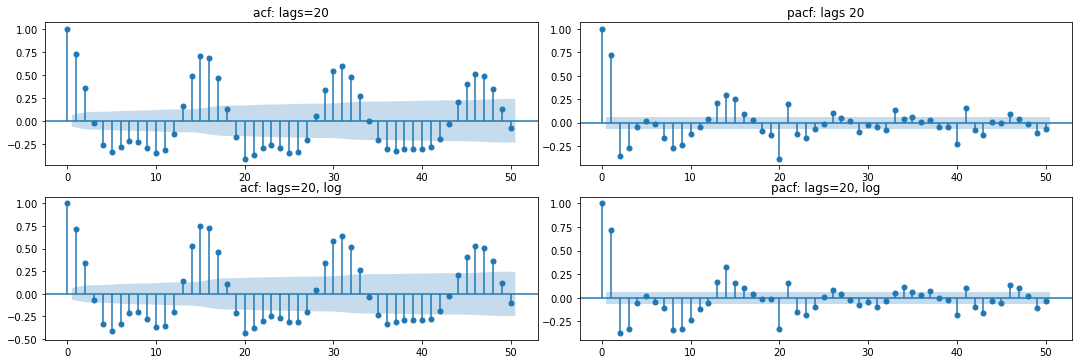

In [958]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
fig.tight_layout()

p00 = 'acf: lags=20'
p01 = 'pacf: lags 20'
p10 = 'acf: lags=20, log'
p11 = 'pacf: lags=20, log'
_=sm.graphics.tsa.plot_acf(orders_per_hour_bh['diff'], lags=50, ax=ax[0,0], title=p00)
_=sm.graphics.tsa.plot_pacf(orders_per_hour_bh['diff'], lags=50, ax=ax[0,1], title=p01)
_=sm.graphics.tsa.plot_acf(orders_per_hour_bh['diff_ln_oph'], lags=50, ax=ax[1,0], title=p10)
_=sm.graphics.tsa.plot_pacf(orders_per_hour_bh['diff_ln_oph'], lags=50, ax=ax[1,1], title=p11)